In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import ast 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score,mean_squared_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score


# Movie Recommendation Project

In this project we will try to predict which movie should be your next movie.

At first, as a POC we will build a recommendation system that is content based filtering, the system will offer generalized recommendations to every user based on the popularity, the genres and the movie's runtime. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Later on, we will try to extend the algorithm with adding demographic filtering based models. Giving a user a more specific recommendation based on his rating on other movies and taking into consideration the popularity of a certian genres in the year he is watching.
 
Some interesting analysis we are hoping to come a cross while working on this:

- Genre popularity based on the year, we can tell by that if there was a major event that may cause a specific genre to be more popular
- What is the perfect runtime? is there such a thing?
- What year is the best year to release movie?
- Are people consistently watching the same genre films? e.g. People who watch war, crime and thriller films likely to watch only those genres

_Because of low-quality data on old movies, we will **not** ignore movies that were released after the year of watching parameter._

## Let's look at our data

In [2]:
# movies_raw_df = pd.read_csv('https://www.dropbox.com/s/mfe0v4ew5fmnyzb/movies.csv?dl=1')
# rating_raw_df = pd.read_csv('https://www.dropbox.com/s/tizyp5zreilielv/ratings.csv?dl=1')

movies_raw_df = pd.read_csv('movies.csv')
ratings_raw_df = pd.read_csv('ratings.csv')

#### MovieLens's Movies Dataset Features:

- adult - Is it an adult film
- budget - How much money was invested
- genres - Genres the movie classified to(JSON format)
- imdb_id - IMDb's ID
- overview - Description of the movie
- popularity - A numeric quantity specifying the movie popularity, the higher the better.
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date of the movie release
- revenue - How much revenue the movie generated worldwide
- runtime - How long is the movie in minutes
- tagline - Movie's tagline
- title - Title of the movie
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

#### Rating Dataset Features:

- userId - A unique value for each user
- movieId - A unique movie id in MovieLens
- rating - The user rating for that movie
- timestamp - The time the movie was rated

## Content-based Filtering

Content-based filtering methods are based on a description of the item and a profile of the user's preferences.
Content-based recommenders treat recommendation as a user-specific classification problem and learn a classifier for the user's likes and dislikes based on an item's features.

### Taking A Look At Our Movies Dataset

#### Cleaning MovieLens's Movies Dataset

REMOVED: 30 duplicates
REMOVED: 84 movies without release year
REMOVED: 40 movies without popularity
REMOVED: 437 movies that not released yet
Cleaning anomalies years, we are left with 1911 to 2017


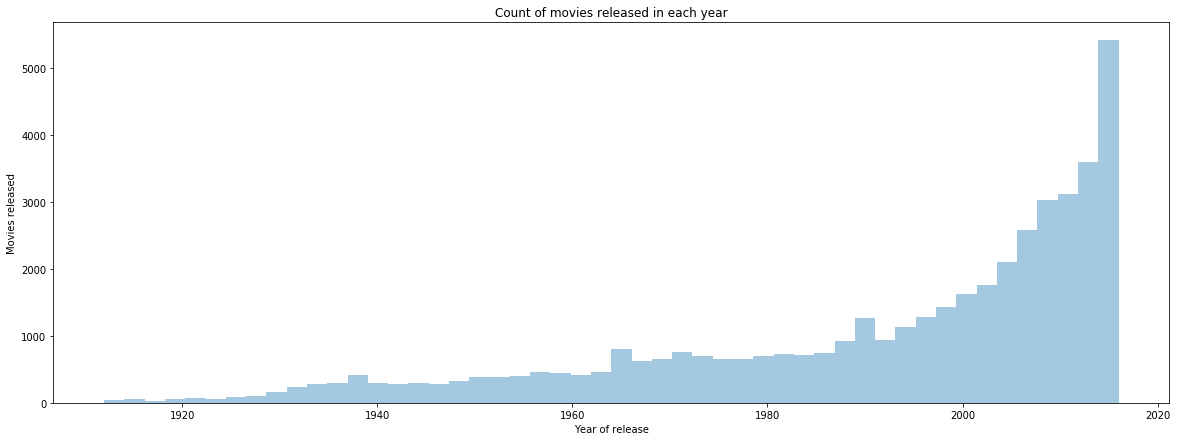

In [3]:
movies_df = movies_raw_df.copy()

# After inspections in df we found duplicated rows so we'll drop the to keep unique values
duplications = len(movies_df['id']) - len(movies_df.drop_duplicates(['id']))
print( 'REMOVED: {} duplicates'.format(duplications) )
movies_df.drop_duplicates(['id'],inplace=True)

# create a new column with the release year
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'],errors='coerce').dt.year.fillna(0)
print( 'REMOVED: {} movies without release year'.format(len(movies_df[ movies_df['release_year'] == 0 ])) )
movies_df = movies_df[ movies_df['release_year'] != 0 ]

# clearing popularity column
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'],errors='coerce')
print( 'REMOVED: {} movies without popularity'.format(len(movies_df[ movies_df['popularity'] == 0 ])) )
movies_df = movies_df[ movies_df['popularity'] != 0 ]

# Remove unreleased films
print( 'REMOVED: {} movies that not released yet'.format(len(movies_df[ movies_df['status'] != 'Released' ])) )
movies_df = movies_df[ movies_df['status'] == 'Released' ]

# finding the longest sequence of years with movie count higher then 10
def find_movies_range(df, threshold):
    # group by year
    groupby_year = df.groupby('release_year').size().reset_index(name='count').sort_values(['release_year'])
    # for each year, if it has sufficient number of movies
    groupby_year['count'] = groupby_year['count'].apply(lambda x: x < threshold)
    groupby_year.reset_index(inplace=True)
    # search for sequence of years with 10 >= movies
    groupby_year = groupby_year.groupby(groupby_year['count'].cumsum()).agg(
        {'release_year':['count', 'min', 'max']})
    groupby_year.columns = groupby_year.columns.droplevel()
    # get the longest year sequence in the dataset
    return groupby_year[groupby_year['count']==groupby_year['count'].max()]

years_range = find_movies_range( movies_df, 10 )

# clean movies out of limit
movies_df = movies_df[(movies_df['release_year'] > int(years_range['min'].values)) & (movies_df['release_year'] < int(years_range['max'].values))]

print('Cleaning anomalies years, we are left with {} to {}'.format(
    int(years_range['min'].values),int(years_range['max'].values))
)

"""
Preparing our genres column for usage
Genres are stored as JSONs in our dataset, lets convert to it to hot-one format
"""
genres_list = set()
for index, row in movies_df.iterrows(): #Todo its a bad practice to use iterrows 
    # extract genres
    movies_genres = ast.literal_eval(row['genres'])
    for genre in movies_genres:
        # if genre is not a column, generate the column and set all to 0
        if genre['name'] not in movies_df:
            genres_list.add(genre['name'])
            movies_df[ genre['name'] ] = 0
        movies_df.at[index, genre['name']] = 1

# removing unnecessary columns
movies_df.drop(['imdb_id','homepage','adult','belongs_to_collection','production_countries','overview','tagline',
                'video', 'genres','poster_path', 'spoken_languages','status'],inplace=True,axis=1)    

# Get a feeling of the movies and their release year
f, axes = plt.subplots(figsize=(20, 7))
sns.distplot(movies_df['release_year'], ax=axes, kde=False)
plt.xlabel('Year of release')
plt.ylabel('Movies released')
plt.title('Count of movies released in each year')
plt.show()

### Lets look at at the movies's genres

Popularity of movie genres can tell us a lot. in the following segment we will present how many movies in each genre were released each year.

Lets first look how many movies in each genre were released in relation to all movies released in that year.
As a movie can be considered in multiple genres, for our purposes if a movie has 3 genres, then all three are counted.

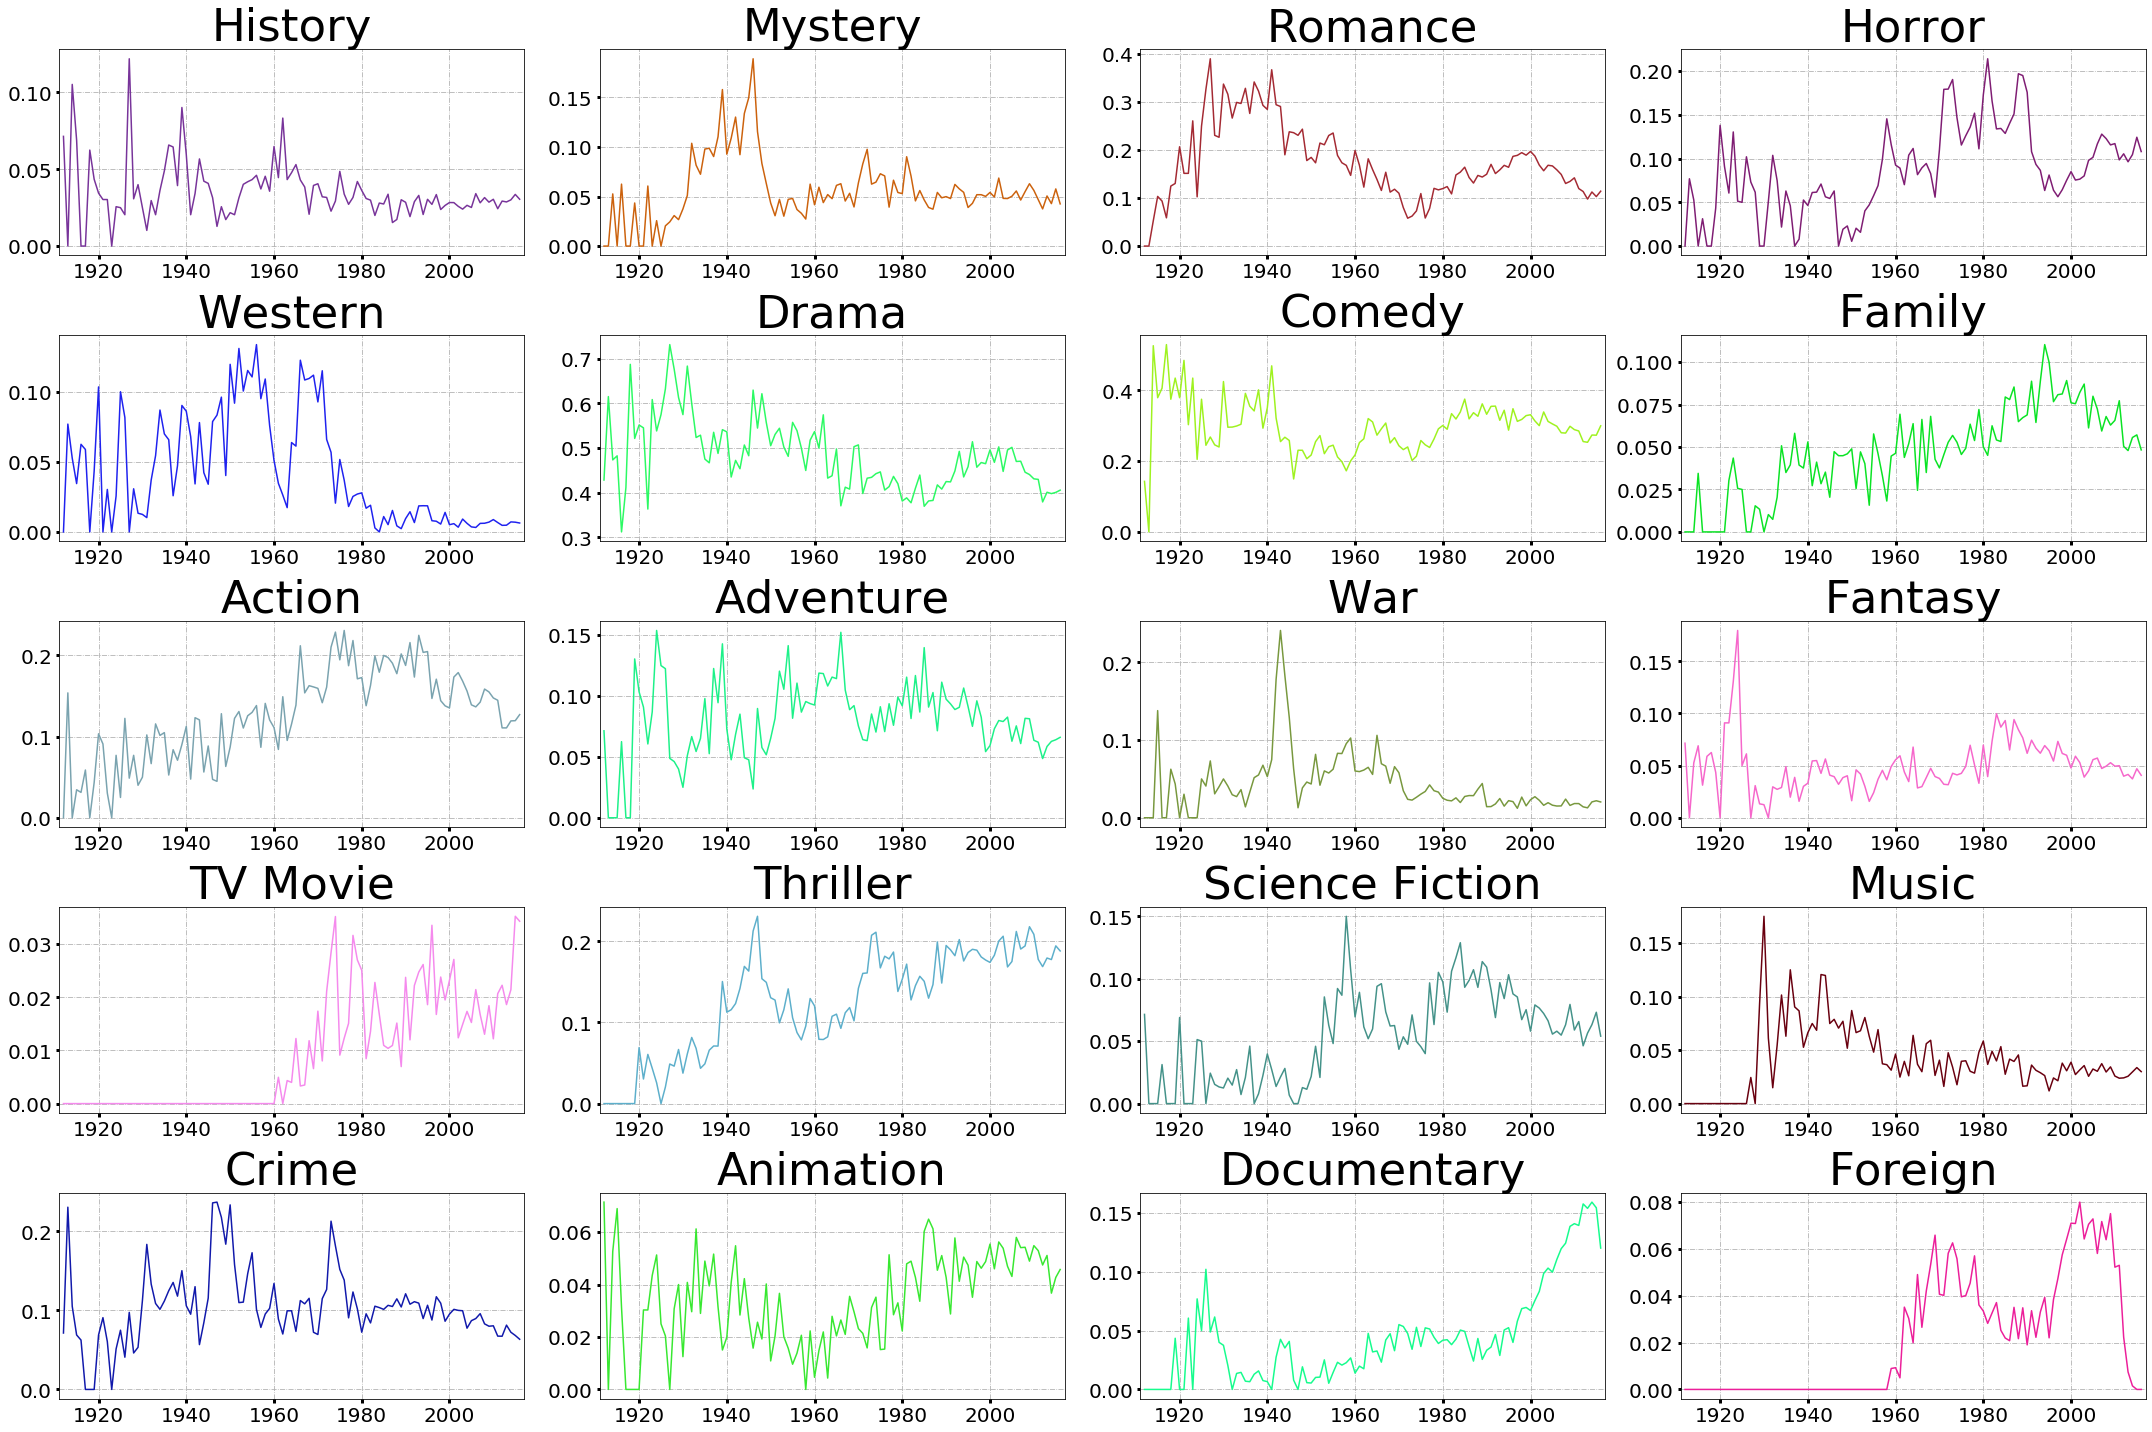

In [4]:
i = 1
fig, axes = plt.subplots(figsize=(30,20))

for genre in genres_list:
    ax = plt.subplot(5,4,i)
    
    d = movies_df[movies_df[genre] == 1].groupby(['release_year',genre]).size().to_frame('count').reset_index()
    d = d.set_index('release_year').drop(genre,axis=1)['count'] / movies_df.groupby('release_year').size()
    d.fillna(0,inplace=True)
    
    sns.lineplot(data=d,color=np.random.rand(3,))
    
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)
    plt.ylabel('')
    plt.xlabel('')
    # plt.ylim(bottom=0,top=1)
    plt.xlim(left=years_range['min'].values,right=years_range['max'].values)
    plt.title(genre, {'size' : '45'})
    i+=1
    
plt.tight_layout()
plt.show()

# TODO: print all the movies genre in the same plot

# fig = plt.figure(figsize=(30,20)) 
# for genre in genres_list:
#     d = movies_df[movies_df[genre] == 1].groupby(['release_year',genre]).size().to_frame('count').reset_index()
#     data = d.set_index('release_year').drop(genre,axis=1)['count'] / movies_df.groupby('release_year').size()
#     data.fillna(0)
#     sns.lineplot(data=data,label=genre)
# plt.legend(loc='best')
# plt.show()

Combining the count of movies released in each year with the following plot, which is showing the median popularity of each 
movie genre in each year we can notice for some intersting insights

#### Some of the insights we can come across while understanding the plots:

- Steady disappearance of Westerns.
- Burst of Musicals on to the scene in the mid-1920s. Then declining since the 1970s.
- Link between Film-Noir and WW2?
- Dwindling popularity of Romance and Action in recent years.
- Increasing popularity of documentaries since the mid 90s.
- Slow increase in popularity of Horror and Thrillers since the 1950s.
- Increase of TV movies as TVs were introduced in the 1940s

This will allow us to tell, in a given year and a genre the propability it will be popular

#### Normalizing our ratings

[based on IMDb's formula](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)

> How do you calculate the rank of movies and TV shows on the Top Rated Movies and Top Rated TV Show lists?
The following formula is used to calculate the Top Rated 250 titles. This formula provides a true 'Bayesian estimate', which takes into account the number of votes each title has received, minimum votes required to be on the list, and the mean vote for all titles:

`weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C`

Where:
- R = average for the movie (mean) = (rating)
- v = number of votes for the movie = (votes)
- m = minimum votes required to be listed in the Top Rated list
- C = the mean vote across the whole report

Please be aware that the Top Rated Movies Chart only includes theatrical features: shorts, TV movies, miniseries and documentaries are not included in the Top Rated Movies Chart. The Top Rated TV Shows Chart includes TV Series, but not TV episodes or Movies.

In [5]:
def calculate_weighted_rate(row):
    m = movies_df['vote_count'].quantile(0.9)
    c = movies_df['vote_average'].mean()
    v = row['vote_count']
    r = row['vote_average']
    res = (v / (v+m)) * r + (m / (v+m)) * c
    return res

movies_df['weighted_rate'] = movies_df.apply(calculate_weighted_rate,axis=1)

movies_df[['original_title','vote_average','weighted_rate']].head()

,original_title,vote_average,weighted_rate
0,Toy Story,7.7,7.639919
1,Jumanji,6.9,6.820204
2,Grumpier Old Men,6.5,5.946166
3,Waiting to Exhale,6.1,5.712889
4,Father of the Bride Part II,5.7,5.666944


### What do we consider a recommended movie?

A movie with weighted rate above average. We think  movie will have a higher probability of being liked by the average audience.

In [6]:
# the recommended film column based on mean
wr_mean = movies_df['weighted_rate'].mean()

# drop the columns that weight rate is based on them
movies_df['recommended'] = movies_df.apply(lambda x: 'True' if x['weighted_rate']>=wr_mean else 'False' ,axis=1)

#### Finding how to produce the most profitble movie

In the following example, we will try to find out the optimal spec a movie need to be most profitble(revenue / budget wise) and to be considered a recommened movie. We will look at the top 1000 recommended and most profitible movies.

Using [median of medians](https://en.wikipedia.org/wiki/Median_of_medians)(The median of medians is a simple approximate selection algorithm) to find the optimal runtime and counting how many movies released in each genre we will produce the optimal formula for a movie.

In [7]:
movies_earn_df = movies_df[ (movies_df['revenue'] > 10**3) & (movies_df['budget'] > 10**3) & (movies_df['recommended'] == 'True') ]

movies_earn_df['r/b'] = movies_earn_df.apply(lambda x: (x['revenue'] / x['budget']),axis=1)
movies_earn_df.sort_values(by=['r/b'],ascending=False,inplace=True)
movies_earn_df = movies_earn_df.head(1000)

runtime_opt_range = {
    'min': int(movies_earn_df[ movies_earn_df['runtime'].median() > movies_earn_df['runtime'] ]['runtime'].median()),
    'max': int(movies_earn_df[ movies_earn_df['runtime'].median() < movies_earn_df['runtime'] ]['runtime'].median())
}

print('Optimal runtime is between {} to {}'.format(runtime_opt_range['min'], runtime_opt_range['max']))

# TODO: print budget

genres_count = pd.DataFrame(columns=genres_list,
                            index=np.arange(years_range['min'].values,years_range['max'].values))
# genres_popularity_sum = pd.DataFrame(columns=genres_list,
#                                     index=np.arange(years_range['min'].values,years_range['max'].values))

for genre in genres_list:
#     genres_popularity_sum[genre] = movies_df[movies_df[genre] == 1].groupby('release_year')['popularity'].sum()
    genres_count[genre] = movies_earn_df[movies_earn_df[genre] == 1].groupby('release_year').size()
genres_count.fillna(0)

print('And the top profitble genres are:')
print(*genres_count.max().sort_values(ascending=False).head(5).index, sep = ", ")


Optimal runtime is between 96 to 125
And the top profitble genres are:
Drama, Comedy, Action, Horror, Romance


C:\Anaconda2\envs\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda2\envs\env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Lets create a model to try to predict if a movie is recommended

The model will try to predict if a movie will have an above avarage rate just by the runtime, popularity and the movie's genres.

#### Lets fit our model

At first the recommendation prediciton will be based on the runtime, popularity and genres columns.

We will use 3 different models, and we will choose the best one.

In [8]:
movies_data_df = movies_df.drop(columns=['id','original_title', 'title','release_date','revenue','budget',
                                         'weighted_rate','vote_average', 'vote_count'])

def combine_features(row):
    feature = row['original_language'] 
    for company in ast.literal_eval(row['production_companies']):
        try:
            feature += " " + company['name']
        except:
            pass
    return feature

movies_data_df["combined_features"] = movies_df.apply(combine_features,axis=1)
movies_data_df["combined_features"].fillna('',inplace=True)
movies_data_df['runtime'].fillna(0,inplace=True)
movies_data_df.drop(columns=['production_companies', 'original_language','combined_features'],inplace=True)
movies_data_df.head()

,popularity,runtime,release_year,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,...,History,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,recommended
0,21.946943,81.0,1995.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
1,17.015539,104.0,1995.0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,True
2,11.712900,101.0,1995.0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,True
3,3.859495,127.0,1995.0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,False
4,8.387519,106.0,1995.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False


In [9]:
Xs = movies_data_df.drop('recommended',axis=1)
y = movies_data_df['recommended']
X_train,X_test,y_train,y_test = train_test_split(Xs,y,test_size=0.20,random_state=0)
X_train.shape,X_test.shape


ML_models = {}
model_index = ['LR','RF','NN']
model_sklearn = [LogisticRegression(solver='liblinear',random_state=0),
                 RandomForestClassifier(n_estimators=100,random_state=0),
                 MLPClassifier([100]*5,early_stopping=True,learning_rate='adaptive',random_state=0)]

model_summary = []

for name,model in zip(model_index,model_sklearn):
    ML_models[name] = model.fit(X_train,y_train)
    preds = model.predict(X_test)
    model_summary.append([name,f1_score(y_test,preds,average='weighted'),accuracy_score(y_test,preds),
                          roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),])\
    
print(ML_models)

model_summary = pd.DataFrame(model_summary,columns=['Name','F1_score','Accuracy','AUC_ROC'])
model_summary = model_summary.reset_index()
display(model_summary)

{'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'RF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False), 'NN': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, ea

,index,Name,F1_score,Accuracy,AUC_ROC
0,0,LR,0.814021,0.827337,0.864917
1,1,RF,0.842552,0.846458,0.895548
2,2,NN,0.817574,0.829713,0.883772


### Small summary

We tested 3 different algorithms and found out that the most accurate one to predict a 'recommended movie' is RandomForestClassifier algorithm.
This is just by the genres of the film, it's runtime and how popular he was.

In [10]:
# def generate_movie_row(data):
    

# optimal runtime is between 86 to 112
# optimal release years are between 1975 to 2009
X2_train = X_train#.drop('popularity',axis=1)
classifier = RandomForestClassifier(n_estimators=100,random_state=0)
classifier.fit(X2_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
# TODO: refactor to recreate optimal movies

def generate_opt_movie(year, genres):
    pop = (genres_opt.loc[year]['Adventure'] + genres_opt.loc[year]['Action'] + genres_opt.loc[year]['Drama'])/3
    
    optimal_movie = {
        'runtime': np.random.randint(low=runtime_opt_range['min'], high=runtime_opt_range['max']),
        'release_year': rnd_year,
        'Adventure': 1,
        'Action': 1,
        'Drama':1,
        'popularity': pop
    }


optimal_movie = pd.DataFrame([optimal_movie],columns=movies_data_df.columns)
optimal_movie.fillna(0,inplace=True)
optimal_movie.drop(['recommended'],inplace=True,axis=1)

print(classifier.predict(optimal_movie))

NameError: name 'optimal_movie' is not defined

# #TODO: K-means here
**First we set a new df to be a proper and cleaner set, we keep only the genres, ids and titles of the movie.**

In [53]:
generes_df = movies_raw_df.loc[:, ('genres', 'title', 'id')]
generes_df.drop_duplicates(['id'], inplace=True)
generes_df.dropna()

"""
Preparing our genres column for usage
Genres are stored as JSONs in our dataset, lets convert to it to hot-one format
"""
genres_list = set()
for index, row in generes_df.iterrows():  # Todo its a bad practice to use iterrows
    # extract genres
    movies_genres = ast.literal_eval(row['genres'])
    for genre in movies_genres:
        # if genre is not a column, generate the column and set all to 0
        if genre['name'] not in generes_df:
            genres_list.add(genre['name'])
            generes_df[genre['name']] = 0
        generes_df.at[index, genre['name']] = 1
generes_df.drop(columns=['genres'], inplace=True)
generes_df.set_index('id', inplace=True)

# Now for every user we will its genres ratings

genres = list(generes_df.drop(columns=['title']).columns)
genre_ratings = pd.DataFrame()
for genre in genres:
    genre_movies = generes_df[generes_df[genre] == 1]
    avg_genre_votes_per_user = ratings_raw_df[ratings_raw_df['movieId'].isin(
        genre_movies.index)].loc[:, ['userId', 'rating']].groupby(
        ['userId'])['rating'].mean()
    genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
genre_ratings.columns = genres

# Where we np.nan means that the user didnet arted a movie out of this genre, well engage this by setting it to 0.
genre_ratings.fillna(0,inplace=True)

**Now when the Data is clean for use lets try to decribe it a little and then to choose the clustering methodolgy**
**Our key goal will be to understnad the users favorite genresand than to recomnd by it**

As We can see we have 265k users with their ratings over 20 genres

_Noticeable is the missing values for users that didnt watched movies so we'll get it dont later_

In [54]:
print(genre_ratings.head(3))
print(genre_ratings.shape)

   Animation  Comedy  Family  Adventure  Fantasy   Romance  Drama  Action  \
1        0.0    4.25     0.0        0.0     0.00  3.333333  4.125    3.50   
2        0.0    2.80     1.5        3.5     3.25  4.000000  3.000    3.75   
3        0.0    3.20     0.0        0.0     3.00  3.333333  3.400    3.00   

      Crime  Thriller  Horror  History  Science Fiction  Mystery  War  \
1  4.500000       0.0     0.0      0.0              0.0      1.0  0.0   
2  3.000000       4.0     4.0      3.5              4.0      3.5  3.0   
3  2.666667       2.5     0.0      0.0              3.0      3.0  0.0   

   Foreign  Music  Documentary  Western  TV Movie  
1      3.5    0.0          5.0      0.0       0.0  
2      0.0    1.0          0.0      0.0       0.0  
3      0.0    0.0          0.0      0.0       0.0  
(265848, 20)


### Choosing the Right K Number of Clusters
##### Elbow Method
The elbow method is used for determining the correct number of clusters in a dataset.
we calcualte the Variance ratio which is determined by the Variance Between groups / Total Varince 
> It works by plotting the ascending values of K versus the total error obtained when using that K.

###### the K that was determined is K=7

In [49]:
# Lets get only the Pepole who rated movies that related to comedy and adventure genres 
comedy_adven_df = genre_ratings[['Comedy','Adventure']]
comedy_adven_df = comedy_adven_df[(comedy_adven_df['Comedy']>0) | (comedy_adven_df['Adventure']>0)]
X = comedy_adven_df.values
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, 20)
# Define function to calculate the clustering errors
def clustering_errors(k, data,counter = 0):
    counter = counter+1
    print("predict no: "+str(counter))
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

predict no: 1


KeyboardInterrupt: 

###### Now lets cluster the two genres and  try to figure out how the users are grouped 
The Methodolgy we choose is KMeans

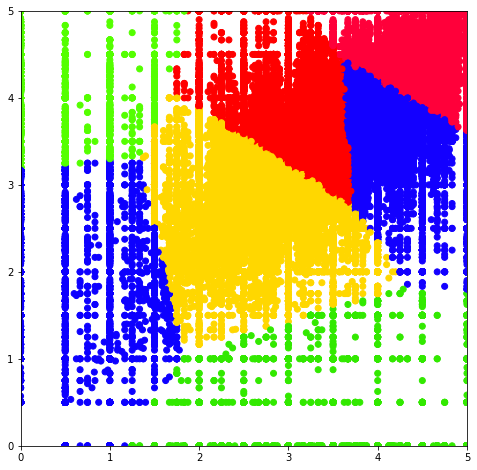

In [55]:
comedy_adven_df = genre_ratings[['Comedy','Adventure']]
comedy_adven_df = comedy_adven_df[(comedy_adven_df['Comedy']>0) | (comedy_adven_df['Adventure']>0)]

X_comedy_adven = comedy_adven_df.values

# Lets create an object of KMeans and cluster comedy and adventure genres 
kmeans_model = KMeans(n_clusters=7)
predictions = kmeans_model.fit_predict(X_comedy_adven)

# Defining the cluster
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.xlim(0, 5)
plt.ylim(0, 5)
clustered = pd.concat([genre_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
plt.scatter(comedy_adven_df['Adventure'],comedy_adven_df['Comedy'],c=predictions, cmap='prism')

In [ ]:
len(movies_df[(movies_df['budget']!=0) & (movies_df['revenue']!=0)])

In [ ]:
## Collaborative Filtering

Collaborative filtering is a way recommendation systems filter information by using the preferences of other people.
It uses the assumption that if person A has similar preferences to person B on items they have both reviewed,
then person A is likely to have a similar preference to person B on an item only person B has reviewed.

### Cleaning ratings dataset

rating dataset is huge, we will take a sample of million rows

## Collaborative Filtering

Collaborative filtering is a way recommendation systems filter information by using the preferences of other people.
It uses the assumption that if person A has similar preferences to person B on items they have both reviewed,
then person A is likely to have a similar preference to person B on an item only person B has reviewed.

### Cleaning ratings dataset

rating dataset is huge, we will take a sample of million rows

In [ ]:
ratings_df = ratings_raw_df.sample(n=10**6, random_state=1)

# convert rating timestamp to date
ratings_df['date'] = ratings_df.apply(lambda x: str(datetime.fromtimestamp(x['timestamp']).strftime('%Y-%m-%d')),axis=1)
#extract release year
ratings_df['vote_year'] = pd.to_datetime(ratings_df['date']).dt.year

#### Get a feeling of the ratings data set

lets check out the movies rating years and the checking the ratings means distributions

In [ ]:
print('movies rating years distributions')
sns.distplot(ratings_df['vote_year'],
                  kde_kws={"color": "k","label": "KDE"})
plt.show()

print('count of ratings')
# TODO: maybe make this as bars?
ratings_count = ratings_df.groupby(by=['rating']).size()
axes = sns.lineplot(data=ratings_count, palette="tab10")
axes.grid(True, linestyle='-.')
plt.show()

We can see that most of the votes are higher than 3, with the most popular vote be 4.

#### Looking at the vote count and vote average

As shown in the graph below, we can see that the `vote_average` feature, which represents the average ratings that the movie recieved doesn't corresponds with the `vote_count`.
We can see by that there are movies with high vote average but small number of voters, it doesn't necessarily mean that it's better than a movie with a smaller vote average but with high number of voters.

In [ ]:
sns.scatterplot(y='vote_count', x='vote_average',data=movies_df[['vote_count','vote_average']])